In [1]:
import scipy.io as sio
import numpy as np 
import sys 
from matplotlib import pyplot as plt
from numba import jit

from sklearn.decomposition import NMF

In [ ]:
# #145 145 220
# def main():
#     # See https://rslab.ut.ac.ir/data for information about this dataset (Urban)
#     hs_image = sio.loadmat("data/Urban_R162.mat")
#     # print(type(hs_image))

#     # for key in hs_image:
#     #     print(key)

#     # Channels that are kept 
#     # print(hs_image["SlectBands"])

#     # Size of image 
#     # print(hs_image["nRow"])
#     # print(hs_image["nCol"])

#     # Number of wavelengths 
#     # print(hs_image["nBand"])

#     # Matrix itself 
#     # print(hs_image["Y"])

#     # Not sure what this mean 
#     # print(hs_image["maxValue"])

    
#     matrix = np.array(hs_image["Y"])

#     # Each row correspond to a channel/wavelength and the image is vectorized as a row vector (I am not sure how it is being flatten) 
#     # I am not sure what the value in the matrix mean. They range from 0 to 1000. I am guessing it is how much is captured by a particular channel after normalization  
#     print(matrix)

# main()

In [ ]:
# hs_image = sio.loadmat("data/Urban_R162.mat")
# for key in hs_image:
#     print(key)

# X = np.array(hs_image["Y"])
# model = NMF(n_components=6, init='random', random_state=0, max_iter=20000)
# W = model.fit_transform(X)
# H = model.components_

In [ ]:
# for i in range(0,6):
#     fst_row = H[i]
#     fst_image = H[i].reshape((307, 307))

#     plt.imshow(fst_image, interpolation='nearest')
#     plt.show()

In [14]:
@jit(nopython=True, parallel=True)
def nmf_hs(X, delta, iters, components):
    (rows, cols) = X.shape
    A = np.random.rand(rows, components)
    S = np.random.rand(components, cols)
    all_delta_X = delta * np.ones((1, cols))
    all_delta_A = delta * np.ones((1, components))
    X_bar = np.vstack((X, all_delta_X))
    for _ in range(0, iters):
        A = A * (X @ np.transpose(S)) / (A @ S @ np.transpose(S))
        A_bar = np.vstack((A, all_delta_A))
        S = S * (np.transpose(A_bar) @ X_bar) / (np.transpose(A_bar) @ A_bar @ S)
        print(np.linalg.norm(X - A @ S))
    error = (np.linalg.norm(X - A @ S))
    return A, S, error 

In [20]:
hs_image = sio.loadmat("data/Urban_R162.mat")
X = np.array(hs_image["Y"]).astype(np.float64)

W, H, error = nmf_hs(X, 1000.0, 1000, 6)
error 

442923.61716225697
282969.2320544492
260801.41144322557
251935.61580964547
247079.0267630775
243897.56711036863
241549.3902609577
239647.62704400977
237971.44839096302
236362.05274446632
234675.08162921845
232752.3039321788
230400.68254098104
227376.88458203856
223382.3677886177
218081.50982989062
211160.17576801457
202434.2711766217
191983.63262586758
180234.49647219275
167901.38445949013
155782.97317333973
144525.99842895154
134490.30323320304
125753.78755709932
118204.39811312662
111647.11396921851
105882.75365715729
100748.48443333246
96128.19118352998
91945.62205764017
88151.31349693495
84710.44494674912
81594.93347356733
78780.00907086699
76243.6470104706
73966.76607133668
71932.77337500051
70126.16818910775
68530.80833882587
67128.71609381297
65899.96065014428
64823.53534715622
63878.70176340349
63046.22331392886
62309.147634946115
61653.08227499667
61066.08817874669
60538.366965308334
60061.88732452531
59630.0362113388
59237.327848625784
58879.17275450041
58551.69773611272
5825

27688.131445997325

In [21]:
np.ones((1, 6)) @ H

array([[0.99722231, 0.99749039, 0.99693907, ..., 0.99864492, 0.99854889,
        0.99856552]])

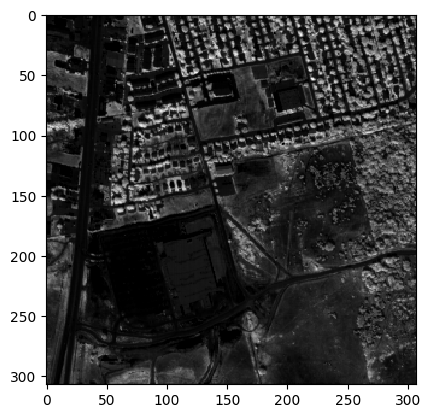

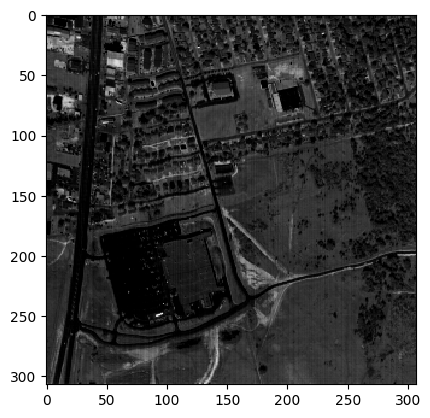

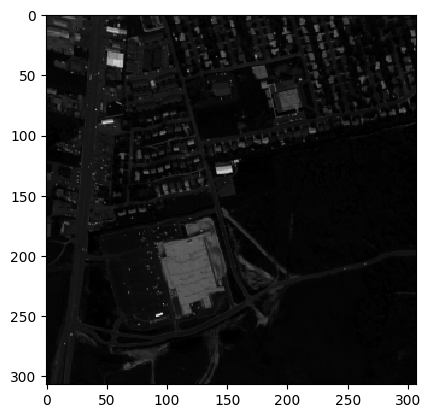

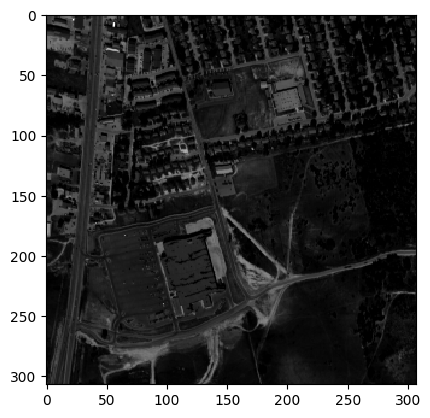

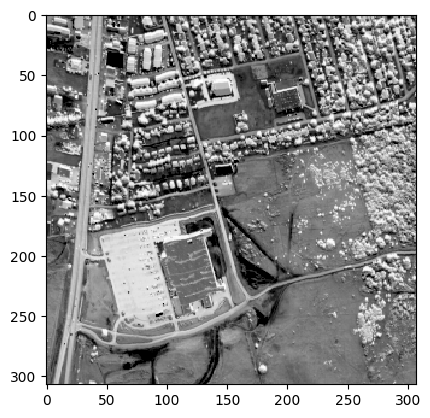

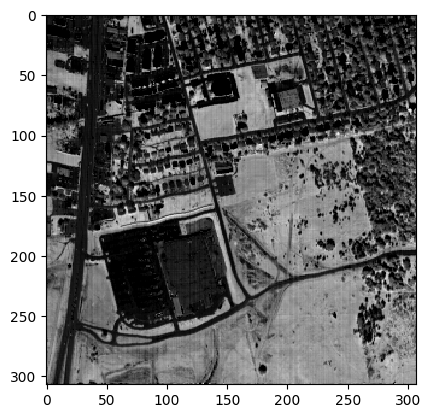

In [23]:
for i in range(0,6):
    fst_row = H[i]
    fst_image = H[i].reshape((307, 307))

    plt.imshow(fst_image, cmap='gray', interpolation='nearest')
    plt.show()